# Risk-Aware RL for Optical Networks — Burst-Aware CVaR

## Experimental Phases
| Phase | Goal |
|-------|------|
| **1** | Validate burst traffic models (known & unknown) |
| **2** | Baseline — standard PPO (no CVaR) with burst traffic |
| **3** | Step-level CVaR PPO vs. baseline |
| **4** | Known burst vs. unknown burst comparison |

---
## 0. Setup & Imports

In [1]:
# Mount Google Drive
from google.colab import drive
import os
from pathlib import Path
import sys

# Detect Colab
try:
    import google.colab  # type: ignore
    drive.mount('/content/drive')
    IN_COLAB = True
except Exception:
    IN_COLAB = False

# Project root
if IN_COLAB:
    # Paths
    DRIVE_ROOT = Path("/content/drive/MyDrive/Colab Notebooks/Risk_aware_RL_0225")
    ZIP_FILE = DRIVE_ROOT / "dependencies_0226.zip"  # Your zipped package on Drive
    PROJECT_ROOT = Path("/content/Risk_aware_RL")

    # Unzip to local runtime (only if not already done)
    if not PROJECT_ROOT.exists():
        print("Extracting package to local runtime...")
        !unzip -q "{ZIP_FILE}" -d "{PROJECT_ROOT}"
        print("✓ Package extracted")
    else:
        print("✓ Package already extracted")

    # Results saved to Drive (persists after disconnect)
    RUNS_DIR = DRIVE_ROOT / "runs"
else:
    PROJECT_ROOT = Path.home() / 'risk_aware_rl_local'
    RUNS_DIR = PROJECT_ROOT / "runs"

PROJECT_ROOT = PROJECT_ROOT.resolve()
RUNS_DIR.mkdir(parents=True, exist_ok=True)

# Add to Python path
if str(PROJECT_ROOT) not in sys.path:
    print('insert project root')
    sys.path.insert(0, str(PROJECT_ROOT))

print(f"IN_COLAB={IN_COLAB}")
print(f"PROJECT_ROOT={PROJECT_ROOT} (local, fast access)")
print(f"RUNS_DIR={RUNS_DIR} (on Drive, persistent)")
print(f"\n✓ All training results will be saved to Google Drive!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ Package already extracted
insert project root
IN_COLAB=True
PROJECT_ROOT=/content/Risk_aware_RL (local, fast access)
RUNS_DIR=/content/drive/MyDrive/Colab Notebooks/Risk_aware_RL_0225/runs (on Drive, persistent)

✓ All training results will be saved to Google Drive!


In [3]:
# Cell 1: Install GPU-enabled PyTorch FIRST
# !pip uninstall torch -y
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

# Verify GPU is available
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}")

Looking in indexes: https://download.pytorch.org/whl/cu121
  Using cached https://download.pytorch.org/whl/cu121/torch-2.5.1%2Bcu121-cp312-cp312-linux_x86_64.whl (780.4 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 84.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 65.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 109.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━

In [5]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from pathlib import Path
from collections import defaultdict
import time
import warnings
warnings.filterwarnings('ignore')

%pip install -r /content/Risk_aware_RL/requirements.txt

In [11]:
# ── Import project modules ────────────────────────────────
from traffic.burst_traffic import (
    BurstTrafficGenerator, BurstConfig, DiurnalConfig,
    diurnal_profile, Service
)
from configs.config import (
    get_default_config, print_config,
    NetworkConfig, TrafficConfig, EnvConfig, TrainingConfig, CVaRConfig
)
from utils.topology import load_topology, compute_ksp, add_link_ids_to_paths
from utils.qot import get_default_modulations, SimpleQoTProvider, GSNRQoTProvider, slots_needed
from utils.criticality import compute_link_criticality_betweenness
from envs.state_encoder import StateEncoder, EncoderConfig
from envs.optical_network_env import OpticalNetworkEnv
from models.step_cvar_ppo import (
    StepCVaRCallback, EpisodeCVaRCallback
)
from utils.windowed_cvar import compute_windowed_cvar

print('All modules imported successfully.')

All modules imported successfully.


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


## Phase 0.5 — Import Config for quick test and real implementation



In [12]:
from datetime import datetime
from configs.config import get_default_config, print_config
from traffic.burst_traffic import BurstConfig, DiurnalConfig
import json, os

config = get_default_config()

# ── Topology ──────────────────────────────────────────────────
topology_name = 'BTUK'
config['network'].topology_name = topology_name
config['network'].topology_path = f"{PROJECT_ROOT}/config_files/topo_{topology_name.lower()}_txOnly.xlsx"
config['network'].gsnr_data_path = f"{PROJECT_ROOT}/config_files/{topology_name.lower()}_roadm_all_pairs_ksp_gsnr.pkl"

# ── Traffic (all times in seconds) ────────────────────────────
# To have a quick test, use high load and 1-hour episode length
# To real implementation, use normal load and 24-hour episode length
config['traffic'].base_load = 1200.0                    # Erlangs
config['traffic'].mean_service_holding_time = 600.0     # 10 min
config['traffic'].bit_rates = [100, 200, 400]
config['traffic'].bit_rate_probabilities = [0.5, 0.3, 0.2]
config['traffic'].episode_duration = 86400             # 1 h (fast); use 86400 for full day
config['traffic'].burst_observable = True               # True = known burst

config['traffic'].burst_config = BurstConfig(
    enabled=True,
    burst_rate_per_day=3.0,
    burst_duration_min_s=300,       # 5 min
    burst_duration_max_s=1800,      # 30 min
    burst_factor_min=2.0,
    burst_factor_max=5.0,
)
config['traffic'].diurnal_config = DiurnalConfig(
    enabled=True, amplitude=0.3, peak_hour=14.0,
)

# ── Environment ───────────────────────────────────────────────
config['env'].blocking_penalty_scale = 1.0
config['env'].bitrate_normalization = min(config['traffic'].bit_rates)  # 100
config['env'].use_mask = True
config['env'].monitoring_window_s = 300.0               # 5-min sliding window

# ── Training ──────────────────────────────────────────────────
config['training'].total_timesteps = 1_000_000
config['training'].n_steps = 2000
config['training'].batch_size = 400
config['training'].n_epochs = 4
config['training'].ent_coef = 0.005
config['training'].device = "cuda"
config['training'].seed = 42

# ── CVaR (nested inside training config) ──────────────────────
config['training'].cvar.enabled = True
config['training'].cvar.alpha = 0.1          # worst 10%
config['training'].cvar.cvar_weight = 0.5    # balance CVaR vs mean
config['training'].cvar.level = 'step'       # step-level reweighting

# ── Output directories ────────────────────────────────────────
timestamp = datetime.now().strftime("%m%d_%H%M")
RESULT_ROOT = os.path.join(PROJECT_ROOT, "results")
EXPERIMENT_DIR = os.path.join(RESULT_ROOT, f"experiment_{timestamp}")
BASELINE_DIR = os.path.join(EXPERIMENT_DIR, "baseline_maskable_ppo")
CVAR_DIR = os.path.join(EXPERIMENT_DIR, "cvar_maskable_ppo")
COMPARISON_DIR = os.path.join(EXPERIMENT_DIR, "comparison")

for d in [BASELINE_DIR, CVAR_DIR, COMPARISON_DIR]:
    os.makedirs(d, exist_ok=True)

# ── Print & save ──────────────────────────────────────────────
print("=" * 70)
print("EXPERIMENT CONFIGURATION")
print("=" * 70)

# Derived quantities
lam = config['traffic'].base_load / config['traffic'].mean_service_holding_time
ep_dur = config['traffic'].episode_duration
print(f"  Arrival rate λ = {lam:.2f} arrivals/s")
print(f"  Expected arrivals/episode ≈ {lam * ep_dur:,.0f}")
print(f"  Burst observable: {config['traffic'].burst_observable}")
print()

print_config(config)
# save_config(config)

# Save config (convert nested dataclasses to dicts for JSON)
def _to_dict(obj):
    if hasattr(obj, '__dict__'):
        return {k: _to_dict(v) for k, v in obj.__dict__.items() if not k.startswith('_')}
    return obj

cfg_path = os.path.join(EXPERIMENT_DIR, 'experiment_config.json')
with open(cfg_path, 'w') as f:
    json.dump({k: _to_dict(v) for k, v in config.items()}, f, indent=2, default=str)
print(f"\n✓ Configuration saved to {cfg_path}")

EXPERIMENT CONFIGURATION
  Arrival rate λ = 2.00 arrivals/s
  Expected arrivals/episode ≈ 172,800
  Burst observable: True


NETWORK:
  topology_name............................. BTUK
  topology_path............................. /content/Risk_aware_RL/config_files/topo_btuk_txOnly.xlsx
  k_paths................................... 5
  bands..................................... ['C', 'L', 'S']
  slots_per_band............................ 400
  slot_bandwidth_ghz........................ 12.5
  guard_band_slots.......................... 1
  gsnr_data_path............................ /content/Risk_aware_RL/config_files/btuk_roadm_all_pairs_ksp_gsnr.pkl
  gsnr_channel_spacing_ghz.................. 50.0

TRAFFIC:
  base_load................................. 1200.0
  mean_service_holding_time................. 600.0
  bit_rates................................. [100, 200, 400]
  bit_rate_probabilities.................... [0.5, 0.3, 0.2]
  episode_duration.......................... 86400
  burst_

In [13]:
import copy
fast_test_config = copy.deepcopy(config)
fast_test_config['traffic'].base_load = 3000
fast_test_config['traffic'].burst_config.burst_rate_per_day = 24
fast_test_config['training'].total_timesteps = 50_000

In [14]:
# ── Select active config ──────────────────────────────────────
# Toggle between real experiment and fast test:
#   active_config = config            # full 24h, 1M steps
#   active_config = fast_test_config  # high load, 50k steps

active_config = config  # ← change this line to switch

# ── Derived constants (read from active config) ──────────────
net_cfg   = active_config['network']
traf_cfg  = active_config['traffic']
env_cfg   = active_config['env']
train_cfg = active_config['training']
cvar_cfg  = train_cfg.cvar

HOLD_TIME     = traf_cfg.mean_service_holding_time
BASE_LOAD     = traf_cfg.base_load
TOTAL_TIMESTEPS = train_cfg.total_timesteps
N_STEPS       = train_cfg.n_steps
SEED          = train_cfg.seed

# ── Training vs Evaluation episode duration ───────────────────
# Training: shorter episodes (2h) with random start hour for diversity
# Evaluation: full episode duration from config (e.g. 24h) for true metrics
TRAIN_EPISODE_DUR = 7200.0    # 2 hours — ~14k steps, good rollout coverage
EVAL_EPISODE_DUR  = traf_cfg.episode_duration   # from config (86400 for real, 3600 for fast)
EPISODE_DUR = EVAL_EPISODE_DUR  # for traffic visiluzition
N_ENVS = 4                    # parallel environments for training

lam = BASE_LOAD / HOLD_TIME
print(f'Active config: base_load={BASE_LOAD}, holding={HOLD_TIME}s')
print(f'  λ = {lam:.2f} arr/s')
print(f'  Training episodes:   {TRAIN_EPISODE_DUR/3600:.0f}h (~{lam*TRAIN_EPISODE_DUR:,.0f} steps) × {N_ENVS} parallel envs')
print(f'  Evaluation episodes: {EVAL_EPISODE_DUR/3600:.0f}h (~{lam*EVAL_EPISODE_DUR:,.0f} steps)')
print(f'  Total timesteps: {TOTAL_TIMESTEPS:,} → ~{TOTAL_TIMESTEPS/(lam*TRAIN_EPISODE_DUR):.0f} training episodes')
print(f'  Burst: rate={traf_cfg.burst_config.burst_rate_per_day}/day, '
      f'factor={traf_cfg.burst_config.burst_factor_min}-{traf_cfg.burst_config.burst_factor_max}x')
print(f'  CVaR: α={cvar_cfg.alpha}, weight={cvar_cfg.cvar_weight}, level={cvar_cfg.level}')

Active config: base_load=1200.0, holding=600.0s
  λ = 2.00 arr/s
  Training episodes:   2h (~14,400 steps) × 4 parallel envs
  Evaluation episodes: 24h (~172,800 steps)
  Total timesteps: 1,000,000 → ~69 training episodes
  Burst: rate=3.0/day, factor=2.0-5.0x
  CVaR: α=0.1, weight=0.5, level=step


---
## Phase 1 — Validate Burst Traffic Models

Generate 24-hour traffic traces with both **known** and **unknown** burst
models.  Verify burst occurrence, rate spikes, and observation differences.

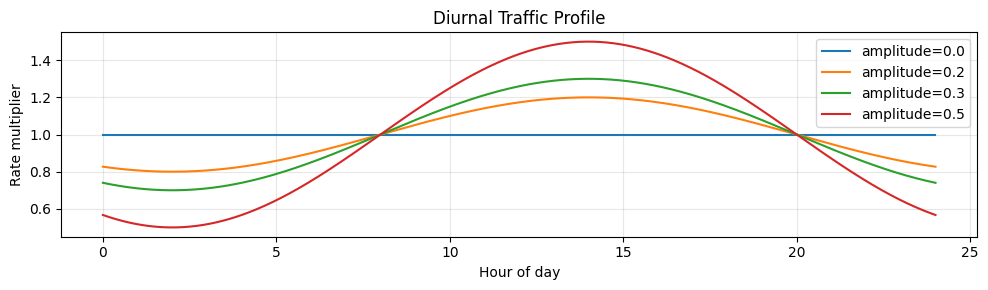

In [9]:
# ── 1.1  Diurnal profile visualisation ────────────────────
t_hours = np.linspace(0, 24, 500)
t_secs  = t_hours * 3600

fig, ax = plt.subplots(figsize=(10, 3))
for amp in [0.0, 0.2, 0.3, 0.5]:
    profile = [diurnal_profile(s, amplitude=amp) for s in t_secs]
    ax.plot(t_hours, profile, label=f'amplitude={amp}')
ax.set_xlabel('Hour of day'); ax.set_ylabel('Rate multiplier')
ax.set_title('Diurnal Traffic Profile'); ax.legend(); ax.grid(alpha=0.3)
plt.tight_layout(); plt.show()

In [10]:
# ── 1.2  Generate a 24-hour trace (Known Burst) ──────────
# All times in SECONDS. Parameters come from active_config (cell 8).

# Load real nodes from topology
topo_for_nodes = load_topology(net_cfg.topology_path, k_paths=net_cfg.k_paths)
real_nodes = sorted(topo_for_nodes.nodes(), key=lambda x: int(x))
print(f'Topology: {net_cfg.topology_name}, {len(real_nodes)} nodes: {real_nodes}')

# Known-burst generator — all params from traf_cfg
tg_known = BurstTrafficGenerator(
    nodes=real_nodes,
    base_load=BASE_LOAD,
    mean_holding_time=HOLD_TIME,
    bit_rates=traf_cfg.bit_rates,
    bit_rate_probs=traf_cfg.bit_rate_probabilities,
    episode_duration=EPISODE_DUR,
    burst_cfg=traf_cfg.burst_config,
    diurnal_cfg=traf_cfg.diurnal_config,
    burst_observable=True,
    seed=SEED,
)
tg_known.reset(seed=SEED)

print(f'\nTraffic parameters (from active_config):')
print(f'  Holding time:   {HOLD_TIME:.0f} s  ({HOLD_TIME/60:.0f} min)')
print(f'  Base load:      {BASE_LOAD:.0f} Erl')
print(f'  Arrival rate λ: {BASE_LOAD/HOLD_TIME:.2f} arrivals/s')
print(f'  Episode:        {EPISODE_DUR/3600:.1f} h')
print(f'  Expected arrivals (no burst): ~{BASE_LOAD/HOLD_TIME * EPISODE_DUR:,.0f}')

# Collect arrivals
arrivals_known = []
while tg_known.current_time < EPISODE_DUR:
    svc = tg_known.generate_service()
    tg_known.record_outcome(True)  # assume all accepted for now
    arrivals_known.append(svc.arrival_time)

arrivals_known = np.array(arrivals_known)
burst_schedule = tg_known.get_burst_schedule()
print(f'\nActual arrivals: {len(arrivals_known):,}')
print(f'Burst events: {len(burst_schedule)}')
for i, b in enumerate(burst_schedule):
    dur_min = (b["end"] - b["start"]) / 60
    print(f'  Burst {i}: t={b["start"]/3600:.1f}h – {b["end"]/3600:.1f}h  '
          f'(duration={dur_min:.0f} min, factor={b["factor"]:.1f}x)')

NameError: name 'load_topology' is not defined

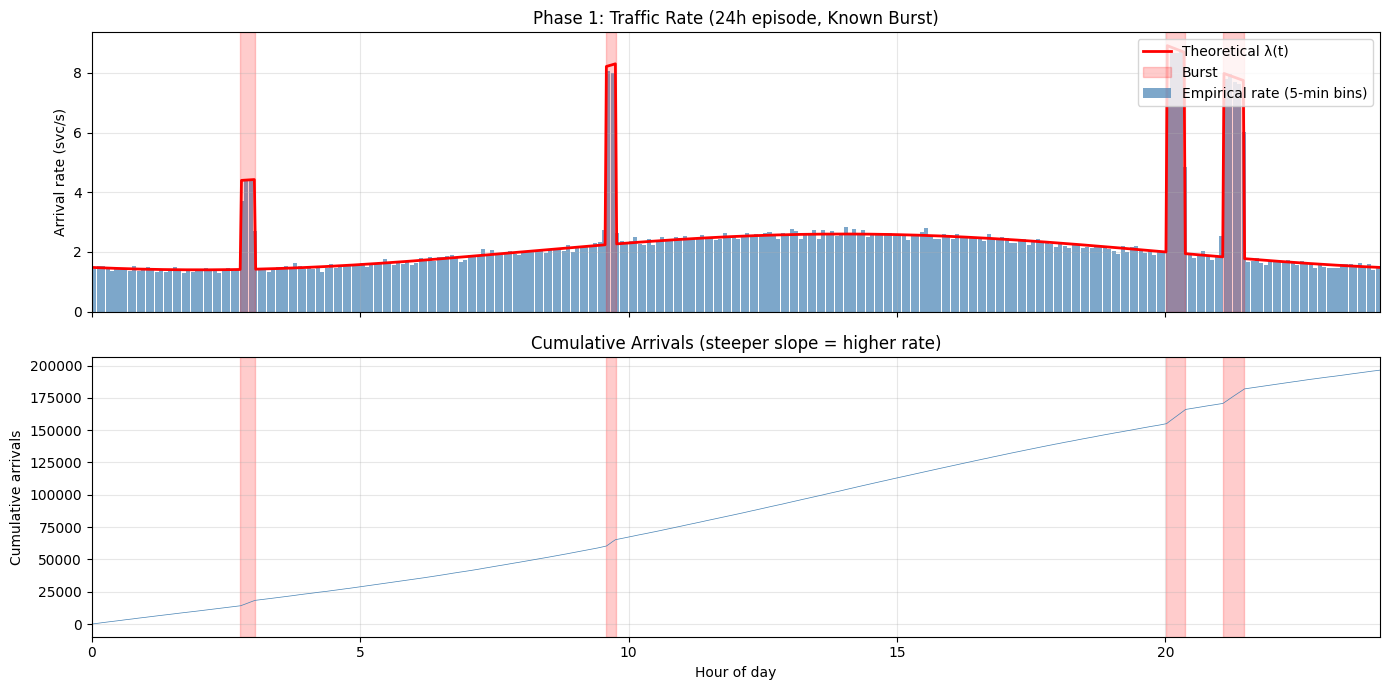

In [13]:
# ── 1.3  Plot arrival rate over episode ───────────────────
fig, axes = plt.subplots(2, 1, figsize=(14, 7), sharex=True)

# Histogram of arrivals → empirical rate
bin_width_s = 300  # 5-min bins
bins = np.arange(0, EPISODE_DUR + bin_width_s, bin_width_s)
counts, edges = np.histogram(arrivals_known, bins=bins)
rate_empirical = counts / bin_width_s  # arrivals per second
bin_centres_h = (edges[:-1] + bin_width_s / 2) / 3600

ax = axes[0]
ax.bar(bin_centres_h, rate_empirical, width=bin_width_s/3600*0.9,
       color='steelblue', alpha=0.7, label='Empirical rate (5-min bins)')

# Overlay theoretical rate
t_plot = np.linspace(0, EPISODE_DUR, 1000)
theoretical_rate = [tg_known._current_rate(t) for t in t_plot]
ax.plot(t_plot / 3600, theoretical_rate, 'r-', lw=2, label='Theoretical λ(t)')

# Shade burst regions
for b in burst_schedule:
    ax.axvspan(b['start']/3600, b['end']/3600, alpha=0.2, color='red',
               label='Burst' if b == burst_schedule[0] else '')

ax.set_ylabel('Arrival rate (svc/s)')
ax.set_title(f'Phase 1: Traffic Rate ({EPISODE_DUR/3600:.0f}h episode, Known Burst)')
ax.legend(loc='upper right'); ax.grid(alpha=0.3)

# Cumulative arrivals
ax = axes[1]
ax.plot(arrivals_known / 3600, np.arange(len(arrivals_known)),
        color='steelblue', lw=0.5)
for b in burst_schedule:
    ax.axvspan(b['start']/3600, b['end']/3600, alpha=0.2, color='red')
ax.set_xlabel('Hour of day'); ax.set_ylabel('Cumulative arrivals')
ax.set_title('Cumulative Arrivals (steeper slope = higher rate)')
ax.grid(alpha=0.3)

ax.set_xlim([0, 24])

plt.tight_layout(); plt.show()

In [14]:
# ── 1.4  Compare Known vs Unknown observation vectors ────
tg_unknown = BurstTrafficGenerator(
    nodes=real_nodes, base_load=BASE_LOAD, mean_holding_time=HOLD_TIME,
    bit_rates=traf_cfg.bit_rates,
    bit_rate_probs=traf_cfg.bit_rate_probabilities,
    episode_duration=EPISODE_DUR,
    burst_cfg=traf_cfg.burst_config,
    diurnal_cfg=traf_cfg.diurnal_config,
    burst_observable=False,   # ← UNKNOWN
    seed=SEED,
)
tg_unknown.reset(seed=SEED)

# Advance both to a burst period
if len(burst_schedule) > 0:
    target_time = burst_schedule[0]['start'] + 60  # 1 min into first burst
else:
    target_time = EPISODE_DUR / 2  # midpoint

# Advance known generator
tg_known.reset(seed=SEED)
while tg_known.current_time < target_time:
    svc = tg_known.generate_service()
    tg_known.record_outcome(True)

# Advance unknown generator
while tg_unknown.current_time < target_time:
    svc = tg_unknown.generate_service()
    tg_unknown.record_outcome(True)

info_known  = tg_known.get_traffic_info()
info_unknown = tg_unknown.get_traffic_info()

print('Traffic info comparison during burst:')
print(f'{"Feature":<25} {"Known":>10} {"Unknown":>10}')
print('-' * 47)
for key in info_known:
    print(f'{key:<25} {info_known[key]:>10.4f} {info_unknown[key]:>10.4f}')

print('\n→ Notice: burst_active, current_rate_norm, burst_remaining_norm')
print('  are zeroed out in the Unknown model.  The agent must rely on')
print('  recent_rate_norm and recent_blocking_rate as indirect signals.')

Traffic info comparison during burst:
Feature                        Known    Unknown
-----------------------------------------------
time_of_day                   0.1160     0.1160
time_of_day_sin               0.6660     0.6660
time_of_day_cos               0.7460     0.7460
recent_rate_norm              0.1562     0.1562
recent_blocking_rate          0.0000     0.0000
current_rate_norm             0.3382     0.0000
burst_active                  1.0000     0.0000
burst_remaining_norm          0.5086     0.0000

→ Notice: burst_active, current_rate_norm, burst_remaining_norm
  are zeroed out in the Unknown model.  The agent must rely on
  recent_rate_norm and recent_blocking_rate as indirect signals.


In [15]:
# ── 1.5  Statistical validation over multiple episodes ────
n_episodes = 20
all_n_arrivals = []
all_n_bursts = []

for ep in range(n_episodes):
    tg = BurstTrafficGenerator(
        nodes=real_nodes, base_load=BASE_LOAD, mean_holding_time=HOLD_TIME,
        bit_rates=traf_cfg.bit_rates,
        bit_rate_probs=traf_cfg.bit_rate_probabilities,
        episode_duration=TRAIN_EPISODE_DUR,
        burst_cfg=traf_cfg.burst_config,
        diurnal_cfg=traf_cfg.diurnal_config,
        burst_observable=True, seed=1000 + ep,
    )
    tg.reset(seed=1000 + ep)
    n = 0
    while tg.current_time < EPISODE_DUR:
        tg.generate_service()
        n += 1
    all_n_arrivals.append(n)
    all_n_bursts.append(len(tg.get_burst_schedule()))

print(f'Over {n_episodes} episodes:')
print(f'  Arrivals/episode: {np.mean(all_n_arrivals):.0f} ± {np.std(all_n_arrivals):.0f}')
print(f'  Bursts/episode:   {np.mean(all_n_bursts):.1f} ± {np.std(all_n_bursts):.1f}')
print(f'  Expected bursts:  {traf_cfg.burst_config.burst_rate_per_day:.1f}')

Over 20 episodes:
  Arrivals/episode: 173215 ± 1009
  Bursts/episode:   0.1 ± 0.3
  Expected bursts:  3.0


---
## Phase 1 ✓ — Traffic models validated

Key observations:
- Diurnal profile modulates baseline rate smoothly (peak at 14:00)
- Burst events produce clear rate spikes (2–5×)
- Known model exposes burst state; Unknown model hides it
- Number of arrivals per episode varies (~5–15%) due to rate variation

---
## Phase 2 — Prepare Network Environment & Baseline PPO

In [15]:
# ── 2.1  Load topology and network data ───────────────────
K = net_cfg.k_paths

print(f'Loading topology: {net_cfg.topology_name}')
topology = load_topology(net_cfg.topology_path, k_paths=K)
print(f'  Nodes: {topology.number_of_nodes()}, Links: {topology.number_of_edges()}')

ksp_dict = compute_ksp(topology, k=K, gsnr_data_path=net_cfg.gsnr_data_path)
add_link_ids_to_paths(topology, ksp_dict)
total_paths = sum(len(p) for p in ksp_dict.values())
print(f'  K-shortest paths: {total_paths} across {len(ksp_dict)} SD pairs')

# QoT provider
modulations = get_default_modulations()
if os.path.exists(net_cfg.gsnr_data_path):
    qot_provider = GSNRQoTProvider(
        gsnr_data_path=net_cfg.gsnr_data_path, modulations=modulations,
        ksp_dict=ksp_dict,
        channel_spacing_ghz=net_cfg.gsnr_channel_spacing_ghz,
        slot_bandwidth_ghz=net_cfg.slot_bandwidth_ghz)
    print('  QoT: GSNR-based')
else:
    path_lengths = {}
    for paths in ksp_dict.values():
        for p in paths:
            path_lengths[p.path_id] = p.length
    qot_provider = SimpleQoTProvider(modulations, path_lengths)
    print('  QoT: Simple length-based')

# Criticality
edge_criticality = compute_link_criticality_betweenness(topology)
print(f'  Criticality range: [{edge_criticality.min():.3f}, {edge_criticality.max():.3f}]')

Loading topology: BTUK
  Loaded topology: 22 nodes, 70 directed edges (35 physical links)
  Nodes: 22, Links: 70
Extracting K-shortest paths from GSNR data...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


  ✓ Extracted 2310 paths for 462 SD pairs
  K-shortest paths: 2310 across 462 SD pairs
  QoT: GSNR-based
  Criticality range: [0.000, 1.000]


In [16]:
# ── 2.2  Create state encoder ─────────────────────────────
BANDS = net_cfg.bands if hasattr(net_cfg, 'bands') and isinstance(net_cfg.bands[0], int) else [0, 1, 2]
SLOTS_PER_BAND = net_cfg.slots_per_band

enc_cfg = EncoderConfig(
    num_nodes=topology.number_of_nodes(),
    bands=BANDS, K=K,
    H_max=topology.number_of_nodes(),
    num_mods=len(modulations),
    delta_norm_db=10.0,
    highrisk_q=env_cfg.highrisk_quantile,
)

def _slots_needed_fn(bitrate, mod, band):
    return slots_needed(bitrate, mod.spectral_efficiency,
                        net_cfg.slot_bandwidth_ghz, net_cfg.guard_band_slots)

encoder = StateEncoder(
    cfg=enc_cfg,
    num_links=topology.number_of_edges(),
    edge_criticality=edge_criticality,
    qot_provider=qot_provider,
    slots_needed_fn=_slots_needed_fn,
)
print(f'Base observation dim: {encoder.obs_dim()}')
print(f'Temporal features:    {8 + 2}')
print(f'Total observation:    {encoder.obs_dim() + 10}')

Base observation dim: 1231
Temporal features:    10
Total observation:    1241


In [17]:
# ── 2.3  Helper: create environment ───────────────────────
def make_env(burst_observable=None, seed=42, mode='train'):
    """
    Create an OpticalNetworkEnv with burst traffic.

    Parameters
    ----------
    mode : 'train' or 'eval'
        'train': shorter episodes, random start hour, scaled burst rate
        'eval':  full-length episodes from config, fixed start at t=0
    """
    if burst_observable is None:
        burst_observable = traf_cfg.burst_observable

    if mode == 'train':
        ep_dur = TRAIN_EPISODE_DUR
        random_start = True
    else:
        ep_dur = EVAL_EPISODE_DUR
        random_start = False

    # Scale burst rate proportionally to episode duration
    scaled_burst_rate = (traf_cfg.burst_config.burst_rate_per_day
                         * ep_dur / 86400.0)
    burst_cfg_scaled = BurstConfig(
        enabled=traf_cfg.burst_config.enabled,
        burst_rate_per_day=scaled_burst_rate,
        burst_duration_min_s=traf_cfg.burst_config.burst_duration_min_s,
        burst_duration_max_s=traf_cfg.burst_config.burst_duration_max_s,
        burst_factor_min=traf_cfg.burst_config.burst_factor_min,
        burst_factor_max=traf_cfg.burst_config.burst_factor_max,
    )

    tg = BurstTrafficGenerator(
        nodes=list(topology.nodes()),
        base_load=BASE_LOAD,
        mean_holding_time=HOLD_TIME,
        bit_rates=traf_cfg.bit_rates,
        bit_rate_probs=traf_cfg.bit_rate_probabilities,
        episode_duration=ep_dur,
        burst_cfg=burst_cfg_scaled,
        diurnal_cfg=traf_cfg.diurnal_config,
        burst_observable=burst_observable,
        random_start_hour=random_start,
        seed=seed,
    )
    env = OpticalNetworkEnv(
        topology=topology, ksp_dict=ksp_dict,
        qot_provider=qot_provider, edge_criticality=edge_criticality,
        encoder=encoder, traffic_generator=tg,
        bands=BANDS, slots_per_band=SLOTS_PER_BAND,
        slot_bandwidth_ghz=net_cfg.slot_bandwidth_ghz,
        guard_slots=net_cfg.guard_band_slots,
        K=K,
        episode_duration=ep_dur,
        monitoring_window_s=env_cfg.monitoring_window_s,
        use_action_masking=env_cfg.use_mask,
        blocking_penalty_scale=env_cfg.blocking_penalty_scale,
        bitrate_normalization=env_cfg.bitrate_normalization,
        seed=seed,
    )
    return env

### Phase 2.a Smoke test using one training episode

In [11]:
# ── 2.4  Smoke test: run one TRAINING episode ─────────────
env = make_env(burst_observable=True, seed=SEED, mode='train')
obs, info = env.reset(seed=SEED)
start_hour = env.traffic_gen.get_start_hour()
print(f'Observation shape: {obs.shape}')
print(f'Action space:      {env.action_space}')
print(f'Episode duration:  {TRAIN_EPISODE_DUR/3600:.1f}h (training mode)')
print(f'Random start hour: {start_hour:.1f}h')

total_reward = 0
steps = 0
done = False
rewards_list = []
times_list = []
blocked_list = []
burst_list = []

while not done:
    mask = env.action_masks()
    valid = np.where(mask)[0]
    action = np.random.choice(valid) if len(valid) > 0 else 0
    obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    total_reward += reward
    rewards_list.append(reward)
    times_list.append(info['current_time'])
    blocked_list.append(info['step_blocking'])
    burst_list.append(info.get('burst_active', 0))
    steps += 1

print(f'\nEpisode complete:')
print(f'  Steps:               {steps:,}')
print(f'  Total reward:        {total_reward:.1f}')
print(f'  Service blocking:    {info.get("episode_service_blocking_rate", 0):.4f}')
print(f'  Burst blocking:      {info.get("episode_burst_blocking_rate", 0):.4f}')
print(f'  Burst events:        {info.get("episode_burst_events", 0)}')
print(f'  Services processed:  {info.get("episode_services_processed", 0):,}')
print(f'  Services accepted:   {info.get("episode_services_accepted", 0):,}')

Observation shape: (1241,)
Action space:      Discrete(15)
Episode duration:  2.0h (training mode)
Random start hour: 18.6h


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag


Episode complete:
  Steps:               14,788
  Total reward:        23823.0
  Service blocking:    0.0421
  Burst blocking:      0.0000
  Burst events:        0
  Services processed:  14,788
  Services accepted:   14,166


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


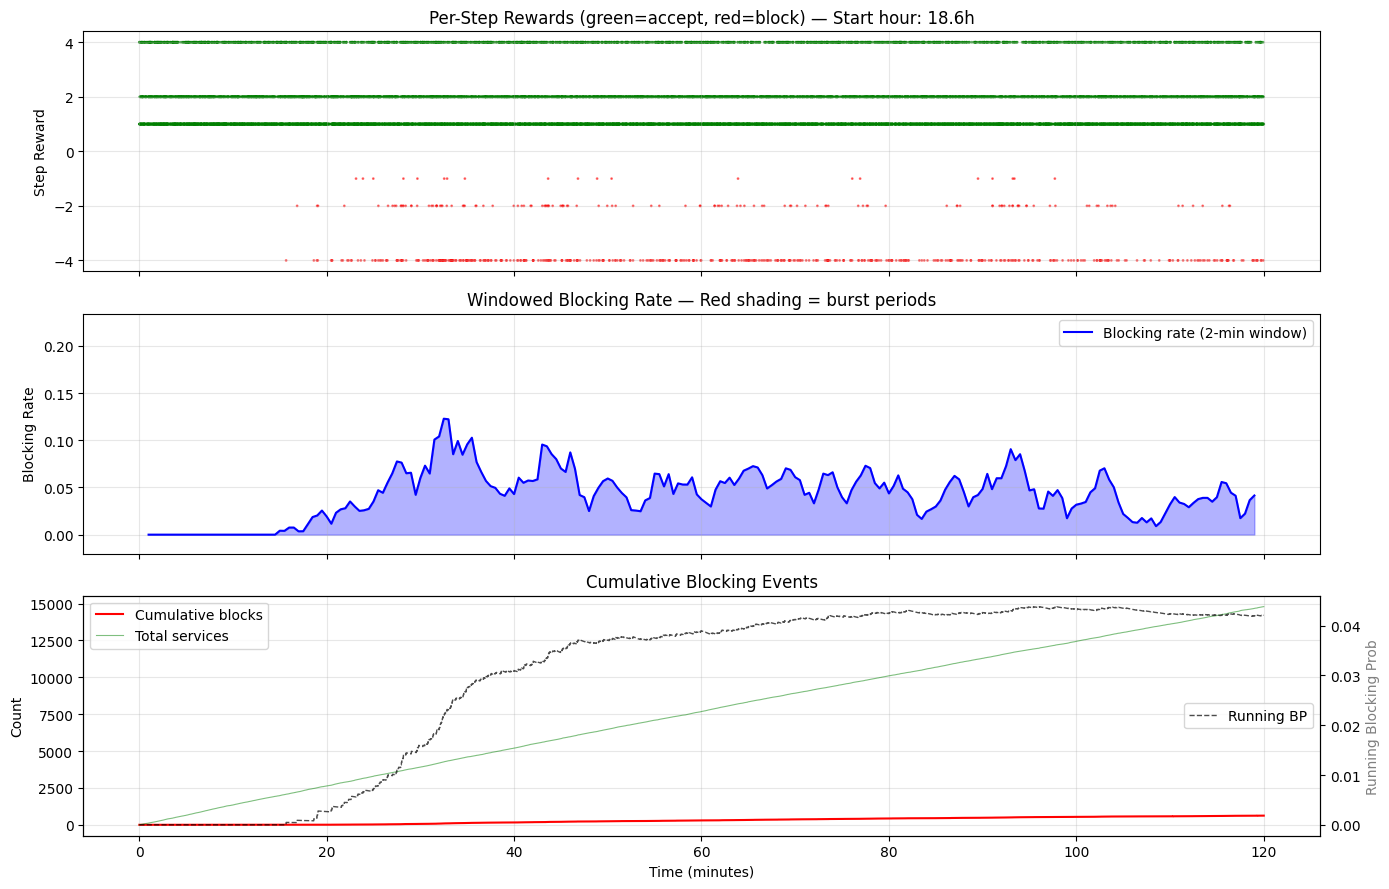


✓ Smoke test complete — blocking visible: 4.21% overall, 0.00% during bursts


In [12]:
# ── 2.5  Visualise per-step blocking over the episode ─────
times_arr = np.array(times_list)
blocked_arr = np.array(blocked_list)
burst_arr = np.array(burst_list)

fig, axes = plt.subplots(3, 1, figsize=(14, 9), sharex=True)

# 1) Per-step rewards
ax = axes[0]
colors = ['green' if r > 0 else 'red' for r in rewards_list]
ax.scatter(times_arr / 60, rewards_list, c=colors, s=1, alpha=0.5)
ax.set_ylabel('Step Reward')
ax.set_title(f'Per-Step Rewards (green=accept, red=block) — '
             f'Start hour: {env.traffic_gen.get_start_hour():.1f}h')
ax.grid(alpha=0.3)

# 2) Windowed blocking rate
ax = axes[1]
window = 120  # 2-min window
stride = 30
t_w, br_w = [], []
t = 0
while t + window <= times_arr.max():
    mask = (times_arr >= t) & (times_arr < t + window)
    n = mask.sum()
    br_w.append(blocked_arr[mask].mean() if n > 0 else 0)
    t_w.append((t + window/2) / 60)
    t += stride

ax.plot(t_w, br_w, 'b-', lw=1.5, label='Blocking rate (2-min window)')
ax.fill_between(t_w, br_w, alpha=0.3, color='blue')

# Shade burst regions
for b in env.traffic_gen.get_burst_schedule():
    ax.axvspan(b['start']/60, b['end']/60, alpha=0.25, color='red',
               label='Burst' if b == env.traffic_gen.get_burst_schedule()[0] else '')

ax.set_ylabel('Blocking Rate')
ax.set_title('Windowed Blocking Rate — Red shading = burst periods')
ax.legend(loc='upper right'); ax.grid(alpha=0.3)
ax.set_ylim(-0.02, min(1.0, max(br_w) * 1.5 + 0.05) if br_w else 1.0)

# 3) Cumulative blocking events
ax = axes[2]
cum_blocked = np.cumsum(blocked_arr)
cum_total = np.arange(1, len(blocked_arr) + 1)
ax.plot(times_arr / 60, cum_blocked, 'r-', lw=1.5, label='Cumulative blocks')
ax.plot(times_arr / 60, cum_total, 'g-', lw=0.8, alpha=0.5, label='Total services')
ax2 = ax.twinx()
running_bp = cum_blocked / cum_total
ax2.plot(times_arr / 60, running_bp, 'k--', lw=1, alpha=0.7, label='Running BP')
ax2.set_ylabel('Running Blocking Prob', color='gray')

for b in env.traffic_gen.get_burst_schedule():
    ax.axvspan(b['start']/60, b['end']/60, alpha=0.15, color='red')

ax.set_xlabel('Time (minutes)')
ax.set_ylabel('Count')
ax.set_title('Cumulative Blocking Events')
ax.legend(loc='upper left'); ax2.legend(loc='right')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(EXPERIMENT_DIR, 'smoke_test_blocking.png'), dpi=150)
plt.show()

env.close()

print(f'\n✓ Smoke test complete — blocking visible: '
      f'{info.get("episode_service_blocking_rate", 0):.2%} overall, '
      f'{info.get("episode_burst_blocking_rate", 0):.2%} during bursts')

### Phase 2.b Baseline running

In [18]:
# ── 2.6  SB3 imports ──────────────────────────────────────
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback, CallbackList

try:
    from sb3_contrib import MaskablePPO
    from sb3_contrib.common.wrappers import ActionMasker
    USE_MASKABLE = True
except ImportError:
    from stable_baselines3 import PPO as MaskablePPO
    USE_MASKABLE = False
    print('sb3-contrib not available; falling back to standard PPO')

print(f'Training config:')
print(f'  timesteps={TOTAL_TIMESTEPS:,}, n_steps={N_STEPS}, '
      f'batch={train_cfg.batch_size}, epochs={train_cfg.n_epochs}')
print(f'  device={train_cfg.device}, seed={SEED}')
print(f'  n_envs={N_ENVS} (SubprocVecEnv)')
print(f'  Maskable PPO: {USE_MASKABLE}')

Training config:
  timesteps=1,000,000, n_steps=2000, batch=400, epochs=4
  device=cuda, seed=42
  n_envs=4 (SubprocVecEnv)
  Maskable PPO: True


In [19]:
# ── Helper: wrap env for SB3 ──────────────────────────────
def make_sb3_env(burst_observable=None, seed=42, log_dir=None, mode='train'):
    """Create a wrapped environment suitable for SB3."""
    def _init():
        env = make_env(burst_observable=burst_observable, seed=seed, mode=mode)
        if USE_MASKABLE:
            env = ActionMasker(env, lambda e: e.unwrapped.action_masks())
        if log_dir:
            os.makedirs(log_dir, exist_ok=True)
            env = Monitor(env, filename=os.path.join(log_dir, f'monitor_{seed}'),
                          info_keywords=('episode_service_blocking_rate',
                                         'episode_burst_blocking_rate'))
        return env
    return _init

def make_parallel_train_env(burst_observable=None, base_seed=42, log_dir=None):
    """Create N_ENVS parallel training environments with different seeds."""
    env_fns = [
        make_sb3_env(burst_observable=burst_observable,
                     seed=base_seed + i,
                     log_dir=log_dir,
                     mode='train')
        for i in range(N_ENVS)
    ]
    # Use SubprocVecEnv for true parallelism (separate processes)
    # Falls back to DummyVecEnv if SubprocVecEnv has issues
    try:
        return SubprocVecEnv(env_fns)
    except Exception as e:
        print(f'SubprocVecEnv failed ({e}), falling back to DummyVecEnv')
        return DummyVecEnv(env_fns)

In [ ]:
# ── Train baseline (known burst, no CVaR) — WITH CHECKPOINT RESUME ────────
import os
import glob
from stable_baselines3.common.callbacks import CheckpointCallback

def find_latest_checkpoint(checkpoint_dir, prefix='model_'):
    """Find the latest checkpoint and return (path, timesteps)."""
    if not os.path.exists(checkpoint_dir):
        return None, 0
    pattern = os.path.join(checkpoint_dir, f'{prefix}*_steps.zip')
    checkpoints = glob.glob(pattern)
    if not checkpoints:
        return None, 0
    def get_timesteps(path):
        try:
            return int(os.path.basename(path).replace('.zip', '').split('_')[1])
        except:
            return 0
    latest = max(checkpoints, key=get_timesteps)
    return latest, get_timesteps(latest)

print('\n' + '='*60)
print('TRAINING: Baseline PPO (Known Burst, No CVaR)')
print(f'  {N_ENVS} parallel envs, {TRAIN_EPISODE_DUR/3600:.0f}h training episodes')
print(f'  Total timesteps target: {TOTAL_TIMESTEPS:,}')
print('='*60)

log_dir_baseline = BASELINE_DIR
checkpoint_dir_baseline = os.path.join(log_dir_baseline, 'checkpoints')
os.makedirs(checkpoint_dir_baseline, exist_ok=True)

# Check for existing checkpoints
latest_ckpt_baseline, completed_steps_baseline = find_latest_checkpoint(checkpoint_dir_baseline)

# Create environments
train_env = make_parallel_train_env(
    burst_observable=True, base_seed=SEED, log_dir=log_dir_baseline)
eval_env = DummyVecEnv([make_sb3_env(
    burst_observable=True, seed=SEED+100, mode='eval')])

# Load or create model
if latest_ckpt_baseline and completed_steps_baseline > 0:
    print(f'\n🔄 RESUMING from checkpoint:')
    print(f'   Path: {os.path.basename(latest_ckpt_baseline)}')
    print(f'   Completed: {completed_steps_baseline:,} / {TOTAL_TIMESTEPS:,} ({100*completed_steps_baseline/TOTAL_TIMESTEPS:.1f}%)')
    
    baseline_agent = MaskablePPO.load(latest_ckpt_baseline, env=train_env, device=train_cfg.device)
    baseline_agent.learning_rate = train_cfg.learning_rate
    remaining_steps_baseline = TOTAL_TIMESTEPS - completed_steps_baseline
else:
    print('\n🆕 Starting fresh training (no checkpoint found)')
    completed_steps_baseline = 0
    baseline_agent = MaskablePPO(
        'MlpPolicy', train_env,
        learning_rate=train_cfg.learning_rate,
        n_steps=N_STEPS,
        batch_size=train_cfg.batch_size,
        n_epochs=train_cfg.n_epochs,
        gamma=train_cfg.gamma,
        gae_lambda=train_cfg.gae_lambda,
        ent_coef=train_cfg.ent_coef,
        clip_range=train_cfg.clip_range,
        max_grad_norm=train_cfg.max_grad_norm,
        policy_kwargs=dict(net_arch=train_cfg.net_arch),
        verbose=0, seed=SEED, device=train_cfg.device,
    )
    remaining_steps_baseline = TOTAL_TIMESTEPS

# Callbacks
ep_cvar_cb_baseline = EpisodeCVaRCallback(alpha=cvar_cfg.alpha)
eval_cb = EvalCallback(eval_env, eval_freq=max(5000, TOTAL_TIMESTEPS // 20),
                       n_eval_episodes=3, best_model_save_path=log_dir_baseline,
                       deterministic=True, verbose=0)
checkpoint_freq = max(50000 // N_ENVS, 2000)
checkpoint_cb = CheckpointCallback(save_freq=checkpoint_freq, save_path=checkpoint_dir_baseline,
                                   name_prefix='model', save_replay_buffer=False, save_vecnormalize=False)

print(f'📁 Checkpoints every {checkpoint_freq * N_ENVS:,} steps to: {checkpoint_dir_baseline}')

# Train
if remaining_steps_baseline > 0:
    print(f'\n🚀 Training {remaining_steps_baseline:,} timesteps...\n')
    t0 = time.time()
    baseline_agent.learn(
        total_timesteps=remaining_steps_baseline,
        callback=CallbackList([eval_cb, checkpoint_cb, ep_cvar_cb_baseline]),
        progress_bar=True,
        reset_num_timesteps=(completed_steps_baseline == 0),
    )
    elapsed = time.time() - t0
    print(f'\n✅ Baseline training complete! Time: {elapsed/60:.1f} min, Speed: {remaining_steps_baseline/elapsed:.1f} steps/sec')
    baseline_agent.save(os.path.join(log_dir_baseline, 'final_model'))
else:
    print('\n✅ Training already complete!')

train_env.close(); eval_env.close()


TRAINING: Baseline PPO (Known Burst, No CVaR)
  4 parallel envs, 2h training episodes


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: 
datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects 
to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)

Output()

/usr/local/lib/python3.12/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

In [ ]:
# ── Baseline Convergence Analysis ─────────────────────────────────────────
print('\n' + '='*60)
print('CONVERGENCE ANALYSIS: Baseline PPO')
print('='*60)

import pandas as pd

def plot_training_convergence(log_dir, title, ep_cvar_callback=None):
    """Plot training convergence metrics."""
    # Load monitor files
    monitor_files = glob.glob(os.path.join(log_dir, '*.monitor.csv'))
    if not monitor_files:
        print(f"No monitor files found in {log_dir}")
        return None
    
    dfs = []
    for f in monitor_files:
        try:
            df = pd.read_csv(f, skiprows=1)
            dfs.append(df)
        except: pass
    
    if not dfs:
        print("No valid monitor data")
        return None
    
    data = pd.concat(dfs, ignore_index=True).sort_values('t').reset_index(drop=True)
    window = min(100, len(data) // 10 + 1)
    data['reward_smooth'] = data['r'].rolling(window=window, min_periods=1).mean()
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(title, fontsize=14, fontweight='bold')
    
    # Episode reward
    ax = axes[0, 0]
    ax.plot(data['r'], alpha=0.3, color='blue')
    ax.plot(data['reward_smooth'], color='blue', linewidth=2, label=f'Smoothed (w={window})')
    ax.set_xlabel('Episode'); ax.set_ylabel('Episode Reward')
    ax.set_title('Episode Reward'); ax.legend(); ax.grid(alpha=0.3)
    
    # Episode length
    ax = axes[0, 1]
    ax.plot(data['l'], alpha=0.5, color='green')
    ax.set_xlabel('Episode'); ax.set_ylabel('Episode Length')
    ax.set_title('Episode Length (services processed)'); ax.grid(alpha=0.3)
    
    # Reward distribution (last 20%)
    ax = axes[1, 0]
    n_recent = max(len(data) // 5, 10)
    recent = data['r'].tail(n_recent)
    ax.hist(recent, bins=30, color='blue', alpha=0.7, edgecolor='black')
    ax.axvline(recent.mean(), color='red', linestyle='--', lw=2, label=f'Mean: {recent.mean():.1f}')
    ax.axvline(recent.quantile(0.1), color='orange', linestyle='--', lw=2, label=f'10th%: {recent.quantile(0.1):.1f}')
    ax.set_xlabel('Episode Reward'); ax.set_ylabel('Count')
    ax.set_title(f'Reward Distribution (last {n_recent} eps)'); ax.legend(); ax.grid(alpha=0.3)
    
    # CVaR tracking
    ax = axes[1, 1]
    if ep_cvar_callback and hasattr(ep_cvar_callback, 'history') and ep_cvar_callback.history['ep_mean']:
        ax.plot(ep_cvar_callback.history['ep_mean'], label='Mean', lw=2)
        ax.plot(ep_cvar_callback.history['ep_cvar'], label=f'CVaR({cvar_cfg.alpha})', lw=2)
        ax.plot(ep_cvar_callback.history['ep_var'], label=f'VaR({cvar_cfg.alpha})', lw=2, ls='--')
        ax.set_xlabel('Rollout'); ax.set_ylabel('Episode Return')
        ax.set_title('Episode CVaR Tracking'); ax.legend(); ax.grid(alpha=0.3)
    else:
        ax.text(0.5, 0.5, 'CVaR data not available', ha='center', va='center', transform=ax.transAxes)
    
    plt.tight_layout()
    plt.savefig(os.path.join(log_dir, 'convergence_analysis.png'), dpi=150, bbox_inches='tight')
    plt.show()
    
    # Print summary
    print(f"\n📊 Training Summary:")
    print(f"   Total episodes: {len(data):,}")
    print(f"   Final reward (last {window}): {data['reward_smooth'].iloc[-1]:.2f}")
    print(f"   Best reward (smoothed): {data['reward_smooth'].max():.2f}")
    print(f"   Mean episode length: {data['l'].mean():.0f} services")
    
    return data

baseline_data = plot_training_convergence(log_dir_baseline, "Baseline PPO Convergence", ep_cvar_cb_baseline)

# Also check evaluation results
eval_file = os.path.join(log_dir_baseline, 'evaluations.npz')
if os.path.exists(eval_file):
    eval_data = np.load(eval_file)
    print(f"\n📈 Evaluation Results:")
    print(f"   Final eval reward: {eval_data['results'].mean(axis=1)[-1]:.2f} ± {eval_data['results'].std(axis=1)[-1]:.2f}")
    print(f"   Best eval reward: {eval_data['results'].mean(axis=1).max():.2f}")


---
## Phase 3 — Step-Level CVaR PPO

Now train with the **StepCVaRCallback** that re-weights advantages to
amplify gradient signal from worst-case timesteps (blocking during bursts).

In [ ]:
# ── Train CVaR PPO (known burst) — WITH CHECKPOINT RESUME ─────────────────
print('\n' + '='*60)
print(f'TRAINING: Step-CVaR PPO (Known Burst, α={cvar_cfg.alpha}, w={cvar_cfg.cvar_weight})')
print(f'  {N_ENVS} parallel envs, {TRAIN_EPISODE_DUR/3600:.0f}h training episodes')
print(f'  Total timesteps target: {TOTAL_TIMESTEPS:,}')
print('='*60)

log_dir_cvar = CVAR_DIR
checkpoint_dir_cvar = os.path.join(log_dir_cvar, 'checkpoints')
os.makedirs(checkpoint_dir_cvar, exist_ok=True)

# Check for existing checkpoints
latest_ckpt_cvar, completed_steps_cvar = find_latest_checkpoint(checkpoint_dir_cvar)

# Create environments
train_env_c = make_parallel_train_env(
    burst_observable=True, base_seed=SEED, log_dir=log_dir_cvar)
eval_env_c = DummyVecEnv([make_sb3_env(
    burst_observable=True, seed=SEED+100, mode='eval')])

# Load or create model
if latest_ckpt_cvar and completed_steps_cvar > 0:
    print(f'\n🔄 RESUMING from checkpoint:')
    print(f'   Path: {os.path.basename(latest_ckpt_cvar)}')
    print(f'   Completed: {completed_steps_cvar:,} / {TOTAL_TIMESTEPS:,} ({100*completed_steps_cvar/TOTAL_TIMESTEPS:.1f}%)')
    
    cvar_agent = MaskablePPO.load(latest_ckpt_cvar, env=train_env_c, device=train_cfg.device)
    cvar_agent.learning_rate = train_cfg.learning_rate
    remaining_steps_cvar = TOTAL_TIMESTEPS - completed_steps_cvar
else:
    print('\n🆕 Starting fresh training (no checkpoint found)')
    completed_steps_cvar = 0
    cvar_agent = MaskablePPO(
        'MlpPolicy', train_env_c,
        learning_rate=train_cfg.learning_rate,
        n_steps=N_STEPS,
        batch_size=train_cfg.batch_size,
        n_epochs=train_cfg.n_epochs,
        gamma=train_cfg.gamma,
        gae_lambda=train_cfg.gae_lambda,
        ent_coef=train_cfg.ent_coef,
        clip_range=train_cfg.clip_range,
        max_grad_norm=train_cfg.max_grad_norm,
        policy_kwargs=dict(net_arch=train_cfg.net_arch),
        verbose=0, seed=SEED, device=train_cfg.device,
    )
    remaining_steps_cvar = TOTAL_TIMESTEPS

# ★ Key: StepCVaRCallback re-weights advantages for tail risk
step_cvar_cb = StepCVaRCallback(alpha=cvar_cfg.alpha, cvar_weight=cvar_cfg.cvar_weight)
ep_cvar_cb_cvar = EpisodeCVaRCallback(alpha=cvar_cfg.alpha)
eval_cb_c = EvalCallback(eval_env_c, eval_freq=max(5000, TOTAL_TIMESTEPS // 20),
                         n_eval_episodes=3, best_model_save_path=log_dir_cvar,
                         deterministic=True, verbose=0)
checkpoint_cb_c = CheckpointCallback(save_freq=checkpoint_freq, save_path=checkpoint_dir_cvar,
                                     name_prefix='model', save_replay_buffer=False, save_vecnormalize=False)

print(f'📁 Checkpoints every {checkpoint_freq * N_ENVS:,} steps to: {checkpoint_dir_cvar}')

# Train
if remaining_steps_cvar > 0:
    print(f'\n🚀 Training {remaining_steps_cvar:,} timesteps...\n')
    t0 = time.time()
    cvar_agent.learn(
        total_timesteps=remaining_steps_cvar,
        callback=CallbackList([eval_cb_c, checkpoint_cb_c, step_cvar_cb, ep_cvar_cb_cvar]),
        progress_bar=True,
        reset_num_timesteps=(completed_steps_cvar == 0),
    )
    elapsed = time.time() - t0
    print(f'\n✅ CVaR training complete! Time: {elapsed/60:.1f} min, Speed: {remaining_steps_cvar/elapsed:.1f} steps/sec')
    cvar_agent.save(os.path.join(log_dir_cvar, 'final_model'))
else:
    print('\n✅ Training already complete!')

train_env_c.close(); eval_env_c.close()

In [ ]:
# ── CVaR PPO Convergence Analysis ─────────────────────────────────────────
print('\n' + '='*60)
print('CONVERGENCE ANALYSIS: Step-CVaR PPO')
print('='*60)

cvar_data = plot_training_convergence(log_dir_cvar, "Step-CVaR PPO Convergence", ep_cvar_cb_cvar)

# Step-level CVaR analysis (advantage reweighting)
if hasattr(step_cvar_cb, 'history') and step_cvar_cb.history['step_cvar']:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Step-CVaR Advantage Reweighting Analysis', fontsize=14, fontweight='bold')
    
    ax = axes[0, 0]
    ax.plot(step_cvar_cb.history['mean_reward'], label='Mean Step Reward', color='blue')
    ax.plot(step_cvar_cb.history['step_cvar'], label=f'Step CVaR({cvar_cfg.alpha})', color='red')
    ax.set_xlabel('Rollout'); ax.set_ylabel('Step Reward')
    ax.set_title('Step-Level Reward Stats'); ax.legend(); ax.grid(alpha=0.3)
    
    ax = axes[0, 1]
    ax.plot(step_cvar_cb.history['tail_frac'], color='purple')
    ax.axhline(y=cvar_cfg.alpha, color='red', ls='--', label=f'Target α={cvar_cfg.alpha}')
    ax.set_xlabel('Rollout'); ax.set_ylabel('Tail Fraction')
    ax.set_title('Fraction of Steps in Tail'); ax.legend(); ax.grid(alpha=0.3)
    
    ax = axes[1, 0]
    ax.plot(step_cvar_cb.history['tail_mean_adv'], label='Tail Adv', color='red')
    ax.plot(step_cvar_cb.history['body_mean_adv'], label='Body Adv', color='green')
    ax.set_xlabel('Rollout'); ax.set_ylabel('Mean Advantage')
    ax.set_title('Advantage by Group'); ax.legend(); ax.grid(alpha=0.3)
    
    ax = axes[1, 1]
    gap = np.array(step_cvar_cb.history['mean_reward']) - np.array(step_cvar_cb.history['step_cvar'])
    ax.plot(gap, color='brown')
    ax.axhline(y=0, color='black', ls='-', alpha=0.3)
    ax.set_xlabel('Rollout'); ax.set_ylabel('Mean - CVaR Gap')
    ax.set_title('Risk Gap (larger = more tail risk)'); ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(log_dir_cvar, 'step_cvar_analysis.png'), dpi=150, bbox_inches='tight')
    plt.show()

# Evaluation results
eval_file_c = os.path.join(log_dir_cvar, 'evaluations.npz')
if os.path.exists(eval_file_c):
    eval_data_c = np.load(eval_file_c)
    print(f"\n📈 Evaluation Results:")
    print(f"   Final eval reward: {eval_data_c['results'].mean(axis=1)[-1]:.2f} ± {eval_data_c['results'].std(axis=1)[-1]:.2f}")
    print(f"   Best eval reward: {eval_data_c['results'].mean(axis=1).max():.2f}")

# Quick comparison
print('\n' + '='*60)
print('QUICK COMPARISON: Baseline vs Step-CVaR')
print('='*60)
if baseline_data is not None and cvar_data is not None:
    print(f"{'Metric':<35} {'Baseline':>12} {'Step-CVaR':>12}")
    print('-'*60)
    print(f"{'Final reward (smoothed)':<35} {baseline_data['reward_smooth'].iloc[-1]:>12.2f} {cvar_data['reward_smooth'].iloc[-1]:>12.2f}")
    print(f"{'Best reward (smoothed)':<35} {baseline_data['reward_smooth'].max():>12.2f} {cvar_data['reward_smooth'].max():>12.2f}")
    print(f"{'10th percentile (last 100)':<35} {baseline_data['r'].tail(100).quantile(0.1):>12.2f} {cvar_data['r'].tail(100).quantile(0.1):>12.2f}")


In [ ]:
# ── 3.2  Evaluate agents ──────────────────────────────────
def evaluate_agent(agent, burst_observable=True, n_episodes=10, label='Agent'):
    """
    Run FULL-LENGTH evaluation episodes and collect detailed metrics.
    Uses mode='eval' → EVAL_EPISODE_DUR, no random start.
    """
    results = defaultdict(list)

    for ep in range(n_episodes):
        env = make_env(burst_observable=burst_observable, seed=5000 + ep,
                       mode='eval')
        if USE_MASKABLE:
            env_wrapped = ActionMasker(env, lambda e: e.unwrapped.action_masks())
        else:
            env_wrapped = env

        obs, _ = env_wrapped.reset()
        done = False
        ep_reward = 0
        ep_times, ep_blocked = [], []

        while not done:
            if USE_MASKABLE:
                masks = env.action_masks()
                action, _ = agent.predict(obs, action_masks=masks, deterministic=True)
            else:
                action, _ = agent.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = env_wrapped.step(action)
            done = terminated or truncated
            ep_reward += reward
            ep_times.append(info.get('current_time', 0))
            ep_blocked.append(info.get('step_blocking', 0))

        results['reward'].append(ep_reward)
        results['sbr'].append(info.get('episode_service_blocking_rate', 0))
        results['burst_bp'].append(info.get('episode_burst_blocking_rate', 0))
        results['n_steps'].append(len(ep_times))

        # Windowed CVaR
        if len(ep_times) > 10:
            wcvar = compute_windowed_cvar(
                np.array(ep_times), np.array(ep_blocked),
                window_s=env_cfg.monitoring_window_s, stride_s=60,
                alpha=cvar_cfg.alpha)
            results['window_cvar'].append(wcvar['window_cvar'])
            results['window_mean'].append(wcvar['window_mean'])
        env.close()

    # Print summary
    print(f'\n{label} — {n_episodes} episodes ({EVAL_EPISODE_DUR/3600:.0f}h each)')
    print(f'  Reward:           {np.mean(results["reward"]):>8.1f} ± {np.std(results["reward"]):.1f}')
    print(f'  Svc Blocking:     {np.mean(results["sbr"]):>8.4f} ± {np.std(results["sbr"]):.4f}')
    print(f'  Burst Blocking:   {np.mean(results["burst_bp"]):>8.4f} ± {np.std(results["burst_bp"]):.4f}')
    if results['window_cvar']:
        print(f'  Window CVaR({cvar_cfg.alpha}): {np.mean(results["window_cvar"]):>8.4f} ± {np.std(results["window_cvar"]):.4f}')
        print(f'  Window Mean BP:   {np.mean(results["window_mean"]):>8.4f}')
    print(f'  Steps/episode:    {np.mean(results["n_steps"]):>8,.0f}')

    return dict(results)

In [ ]:
print('\n' + '='*60)
print('EVALUATION: Baseline vs CVaR (Known Burst)')
print('='*60)

N_EVAL = 10
res_baseline = evaluate_agent(baseline_agent, burst_observable=True,
                              n_episodes=N_EVAL, label='Baseline PPO')
res_cvar = evaluate_agent(cvar_agent, burst_observable=True,
                          n_episodes=N_EVAL, label='Step-CVaR PPO')

In [ ]:
# ── 3.3  Comparison plots ─────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics = [
    ('sbr', 'Service Blocking Rate', 'Overall blocking'),
    ('burst_bp', 'Burst Blocking Rate', 'Blocking during bursts'),
    ('window_cvar', 'Window CVaR(0.1)', 'Worst 10% windows'),
]

for ax, (key, title, ylabel) in zip(axes, metrics):
    data_b = res_baseline.get(key, [0])
    data_c = res_cvar.get(key, [0])

    bp = ax.boxplot([data_b, data_c], labels=['Baseline', 'CVaR'],
                    patch_artist=True)
    bp['boxes'][0].set_facecolor('lightblue')
    bp['boxes'][1].set_facecolor('lightsalmon')
    ax.set_title(title); ax.set_ylabel(ylabel)
    ax.grid(alpha=0.3, axis='y')

fig.suptitle('Phase 3: Baseline PPO vs Step-CVaR PPO (Known Burst)',
             fontsize=13, fontweight='bold')
plt.tight_layout(); plt.show()

In [ ]:
# ── 3.4  CVaR training curves ─────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

h = step_cvar_cb.history
axes[0].plot(h['step_cvar'], label='Step CVaR')
axes[0].plot(h['mean_reward'], label='Mean reward', alpha=0.7)
axes[0].set_title('CVaR vs Mean Reward'); axes[0].legend()
axes[0].set_xlabel('Rollout'); axes[0].grid(alpha=0.3)

axes[1].plot(h['step_var'], label='VaR threshold', color='red')
axes[1].set_title('VaR Threshold (α=0.1)')
axes[1].set_xlabel('Rollout'); axes[1].grid(alpha=0.3)

axes[2].plot(h['tail_frac'], label='Tail fraction', color='purple')
axes[2].set_title('Fraction of Steps in Tail')
axes[2].set_xlabel('Rollout'); axes[2].grid(alpha=0.3)

fig.suptitle('Step-CVaR Training Diagnostics', fontsize=13, fontweight='bold')
plt.tight_layout(); plt.show()

---
## Phase 4 — Known Burst vs. Unknown Burst

Train a CVaR agent in the **unknown burst** scenario and compare.

In [ ]:
# ── 4.1  Train CVaR PPO (Unknown Burst) ───────────────────
print('\n' + '='*60)
print(f'TRAINING: Step-CVaR PPO (Unknown Burst, α={cvar_cfg.alpha}, w={cvar_cfg.cvar_weight})')
print(f'  {N_ENVS} parallel envs, {TRAIN_EPISODE_DUR/3600:.0f}h training episodes')
print('='*60)

log_dir_unknown = os.path.join(EXPERIMENT_DIR, "cvar_unknown_burst")
os.makedirs(log_dir_unknown, exist_ok=True)

train_env_u = make_parallel_train_env(
    burst_observable=False, base_seed=SEED, log_dir=log_dir_unknown)
eval_env_u = DummyVecEnv([make_sb3_env(
    burst_observable=False, seed=SEED+100, mode='eval')])

unknown_agent = MaskablePPO(
    'MlpPolicy', train_env_u,
    learning_rate=train_cfg.learning_rate,
    n_steps=N_STEPS,
    batch_size=train_cfg.batch_size,
    n_epochs=train_cfg.n_epochs,
    gamma=train_cfg.gamma,
    gae_lambda=train_cfg.gae_lambda,
    ent_coef=train_cfg.ent_coef,
    clip_range=train_cfg.clip_range,
    max_grad_norm=train_cfg.max_grad_norm,
    policy_kwargs=dict(net_arch=train_cfg.net_arch),
    verbose=0, seed=SEED, device=train_cfg.device,
)

step_cvar_cb_u = StepCVaRCallback(alpha=cvar_cfg.alpha, cvar_weight=cvar_cfg.cvar_weight)
eval_cb_u = EvalCallback(eval_env_u, eval_freq=max(5000, TOTAL_TIMESTEPS // 20),
                         n_eval_episodes=3,
                         best_model_save_path=log_dir_unknown,
                         deterministic=True, verbose=0)

t0 = time.time()
unknown_agent.learn(
    total_timesteps=TOTAL_TIMESTEPS,
    callback=CallbackList([eval_cb_u, step_cvar_cb_u]),
    progress_bar=True,
)
elapsed = time.time() - t0
print(f'Training time: {elapsed/60:.1f} min ({elapsed/TOTAL_TIMESTEPS*1000:.2f} ms/step)')

train_env_u.close(); eval_env_u.close()

In [ ]:
# ── 4.2  Evaluate all three agents ────────────────────────
print('\n' + '='*60)
print('EVALUATION: All Agents')
print('='*60)

res_baseline_eval = evaluate_agent(baseline_agent, burst_observable=True,
                                   n_episodes=N_EVAL, label='Baseline PPO (Known)')
res_cvar_known    = evaluate_agent(cvar_agent, burst_observable=True,
                                   n_episodes=N_EVAL, label='CVaR PPO (Known)')
res_cvar_unknown  = evaluate_agent(unknown_agent, burst_observable=False,
                                   n_episodes=N_EVAL, label='CVaR PPO (Unknown)')

In [ ]:
# ── 4.3  Three-way comparison plot ────────────────────────
fig, axes = plt.subplots(1, 4, figsize=(18, 5))

all_results = {
    'Baseline\n(Known)': res_baseline_eval,
    'CVaR\n(Known)': res_cvar_known,
    'CVaR\n(Unknown)': res_cvar_unknown,
}
colors = ['lightblue', 'lightsalmon', 'lightgreen']

metrics = [
    ('reward', 'Episode Reward'),
    ('sbr', 'Service Blocking Rate'),
    ('burst_bp', 'Burst Blocking Rate'),
    ('window_cvar', 'Window CVaR(0.1)'),
]

for ax, (key, title) in zip(axes, metrics):
    data = [res.get(key, [0]) for res in all_results.values()]
    bp = ax.boxplot(data, labels=list(all_results.keys()), patch_artist=True)
    for patch, c in zip(bp['boxes'], colors):
        patch.set_facecolor(c)
    ax.set_title(title); ax.grid(alpha=0.3, axis='y')

fig.suptitle('Phase 4: Three-Way Comparison — Baseline vs Known-CVaR vs Unknown-CVaR',
             fontsize=13, fontweight='bold')
plt.tight_layout(); plt.show()

In [ ]:
# ── 4.4  Summary table ────────────────────────────────────
print('\n' + '='*80)
print('SUMMARY TABLE')
print('='*80)
print(f'{"Metric":<25} {"Baseline (Known)":>18} {"CVaR (Known)":>18} {"CVaR (Unknown)":>18}')
print('-'*80)

for key, label in [('reward', 'Episode Reward'),
                    ('sbr', 'Service Blocking'),
                    ('burst_bp', 'Burst Blocking'),
                    ('window_cvar', 'Window CVaR(0.1)'),
                    ('window_mean', 'Window Mean BP')]:
    vals = []
    for res in [res_baseline_eval, res_cvar_known, res_cvar_unknown]:
        d = res.get(key, [0])
        vals.append(f'{np.mean(d):.4f} ± {np.std(d):.4f}')
    print(f'{label:<25} {vals[0]:>18} {vals[1]:>18} {vals[2]:>18}')

print('='*80)

---
## Phase 4 — Detailed Analysis: Episode Trace Comparison

Run one episode for each agent and compare blocking patterns.

In [ ]:
# ── 4.5  Single-episode trace comparison ──────────────────
def run_episode_trace(agent, burst_observable, seed=9999):
    """Run one FULL evaluation episode and return detailed trace."""
    env = make_env(burst_observable=burst_observable, seed=seed, mode='eval')
    if USE_MASKABLE:
        env_w = ActionMasker(env, lambda e: e.unwrapped.action_masks())
    else:
        env_w = env

    obs, _ = env_w.reset()
    trace = {'time': [], 'blocked': [], 'reward': [], 'burst': []}
    done = False

    while not done:
        if USE_MASKABLE:
            masks = env.action_masks()
            action, _ = agent.predict(obs, action_masks=masks, deterministic=True)
        else:
            action, _ = agent.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env_w.step(action)
        done = terminated or truncated
        trace['time'].append(info.get('current_time', 0))
        trace['blocked'].append(info.get('step_blocking', 0))
        trace['reward'].append(reward)
        trace['burst'].append(info.get('burst_active', 0))

    trace['bursts'] = env.traffic_gen.get_burst_schedule()
    trace['info'] = info
    env.close()
    return {k: np.array(v) if isinstance(v, list) else v for k, v in trace.items()}

trace_base = run_episode_trace(baseline_agent, burst_observable=True)
trace_cvar = run_episode_trace(cvar_agent, burst_observable=True)
trace_unkn = run_episode_trace(unknown_agent, burst_observable=False)

In [ ]:
# ── 4.6  Plot episode traces ──────────────────────────────
fig, axes = plt.subplots(3, 1, figsize=(16, 10), sharex=True)

window_s = 120; stride_s = 30

for ax, trace, title, color in [
    (axes[0], trace_base, 'Baseline PPO (Known Burst)', 'steelblue'),
    (axes[1], trace_cvar, 'Step-CVaR PPO (Known Burst)', 'orangered'),
    (axes[2], trace_unkn, 'Step-CVaR PPO (Unknown Burst)', 'forestgreen'),
]:
    times = trace['time']
    blocked = trace['blocked']

    # Windowed blocking rate
    t_w, br_w = [], []
    t = 0
    while t + window_s <= times.max():
        mask = (times >= t) & (times < t + window_s)
        n = mask.sum()
        if n > 0:
            br_w.append(blocked[mask].mean())
        else:
            br_w.append(0)
        t_w.append((t + window_s/2) / 60)
        t += stride_s

    ax.plot(t_w, br_w, color=color, lw=1.5)

    # Shade burst regions
    for b in trace.get('bursts', []):
        ax.axvspan(b['start']/60, b['end']/60, alpha=0.2, color='red')

    info = trace.get('info', {})
    sbr = info.get('episode_service_blocking_rate', 0)
    bbp = info.get('episode_burst_blocking_rate', 0)
    ax.set_title(f'{title}  |  SBR={sbr:.4f}  Burst-BP={bbp:.4f}')
    ax.set_ylabel('Window BP'); ax.grid(alpha=0.3)
    ax.set_ylim(-0.02, 1.0)

axes[-1].set_xlabel('Time (minutes)')
fig.suptitle('Episode Trace: Windowed Blocking Rate (red shading = burst)',
             fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout(); plt.show()

---
## Key Takeaways

### What changed and why it matters

| Aspect | Old (Incorrect) | New (Correct) |
|--------|-----------------|---------------|
| **Traffic** | Stationary Poisson (no bursts) | Time-varying with diurnal + burst events |
| **Episode** | Fixed 1000 services (greenfield) | Fixed 24h (or shorter) wall-clock time |
| **Observation** | No temporal features | Time-of-day, rate, burst state, recent blocking |
| **CVaR level** | Episode-level (tail of days) | Step-level (tail of timesteps = burst moments) |
| **CVaR implementation** | No-op wrapper (just monitoring) | Advantage reweighting in rollout buffer |
| **Metric** | Episode return (total reward) | Burst blocking rate + windowed CVaR |

### Expected results

With sufficient training (500k+ timesteps, 24h episodes):

1. **CVaR PPO should reduce burst blocking** compared to baseline,  
   possibly at the cost of slightly higher overall blocking rate.

2. **Known-burst agent** should outperform unknown-burst agent during bursts,  
   since it can see the burst coming and preemptively conserve spectrum.

3. **Window CVaR** metric should show the clearest difference:  
   the CVaR agent should have lower worst-case window blocking rates.

### Next steps for production

- Scale `EPISODE_DUR` to 86400 (24h) and `TOTAL_TIMESTEPS` to 1M+
- Sweep `cvar_weight` ∈ {0.3, 0.5, 0.7} and `alpha` ∈ {0.05, 0.1, 0.2}
- Add multi-env training (`n_envs > 1`) for speed
- Compare with first-fit heuristic baseline (no RL)